In [1]:
import time
start = time.time()
import timeit
import jax
import jax.numpy as jnp
import numpy as np
import pytest
import scipy.stats
from jax.config import config
from scipy.special import expit
from scipy.special import logit

import inlaw.berry_model as berry_model
import inlaw.inla as inla
import inlaw.quad as quad
import inlaw.smalljax as smalljax

config.update("jax_enable_x64", True)
print('import', time.time()- start)
start = time.time()

# The origin of this test is in conditional_inla.ipynb Take a look there
# for figures showing density comparisons.
n_arms = 4
data = berry_model.figure2_data(1)[:, :n_arms]
sig2_rule = quad.log_gauss_rule(15, 1e-6, 1e3)

fl = inla.FullLaplace(berry_model.berry_model(n_arms), "sig2", data[0])
p_pinned = dict(sig2=sig2_rule.pts, theta=None)

print('create obj', time.time()- start)
start = time.time()
x0 = jnp.zeros((data.shape[0], 15, 4), dtype=data.dtype)
x_max, hess_info, iters = jax.jit(fl.optimizer)(x0, p_pinned, data)
print('optimize', time.time()- start)
start = time.time()

# logdet = jax.vmap(jax.vmap(lambda x: smalljax.logdet(-x)))
logdet = lambda x: jnp.linalg.slogdet(x)[1]
def calc_log_posterior(x_max, hess_info, p_pinned, data):
    lj = fl.log_joint(x_max, p_pinned, data)
    log_post = lj - x_max.dtype.type(0.5) * jnp.linalg.slogdet(hess_info)[1]#logdet(hess_info)
    return log_post

print('set up calc', time.time()- start)
start = time.time()
jax.jit(calc_log_posterior)(x_max, hess_info, p_pinned, data)
print('calc', time.time()- start)

/Users/tbent/.mambaforge/envs/imprint2/lib/python3.10/site-packages/jax/_src/lib/__init__.py:33: UserWarning: JAX on Mac ARM machines is experimental and minimally tested. Please see https://github.com/google/jax/issues/5501 in the event of problems.
  warnings.warn("JAX on Mac ARM machines is experimental and minimally tested. "
/Users/tbent/.mambaforge/envs/imprint2/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


import 0.6206331253051758
create obj 1.123871088027954
1.2730531692504883
set up calc 0.00010919570922851562
calc 0.2518630027770996


In [5]:
import numpyro.handlers as handlers
from functools import partial
@partial(jax.jit, static_argnums=(0,))
def call_model(model, data):
    seeded_model = handlers.seed(model, jax.random.PRNGKey(10))
    trace = handlers.trace(seeded_model).get_trace(data)
    d = {
        k: (v["value"].shape[0] if len(v["value"].shape) > 0 else 1)
        for k, v in trace.items()
        if not v["is_observed"]
    }
    return d
    
call_model(berry_model.berry_model(n_arms), data)

{'sig2': DeviceArray(1, dtype=int64, weak_type=True),
 'theta': DeviceArray(4, dtype=int64, weak_type=True)}

In [ ]:
%%time
logpost, x_max, hess, _ = fl(p_pinned, data, jit=True)

CPU times: user 2.09 s, sys: 34.7 ms, total: 2.13 s
Wall time: 2.06 s


In [70]:
import numpyro.handlers as handlers
def mini(model):
    seeded_model = handlers.seed(model, jax.random.PRNGKey(10))
    def f(p_final, data):
        subs_model = handlers.substitute(seeded_model, p_final)
        trace = handlers.trace(subs_model).get_trace(data)
        return sum(
            [jnp.sum(site["fn"].log_prob(site["value"])) for k, site in trace.items()]
        )
    return f
f = jax.vmap(jax.vmap(mini(berry_model.berry_model(4)), in_axes=(0, None)), in_axes=(None, 0))

In [76]:
merge_vmap = jax.vmap(
    jax.vmap(lambda x, y: inla.merge(fl.spec.unravel_f(x), y), in_axes=(0, 0)),
    in_axes=(0, 0),
)
merge_vmap(x0, p_pinned)

ValueError: vmap got inconsistent sizes for array axes to be mapped:
the tree of axis sizes is:
(1, {'sig2': 15, 'theta': None})

In [71]:
%%time
jax.hessian(p_pinned, data)

CPU times: user 403 ms, sys: 8.87 ms, total: 412 ms
Wall time: 407 ms


DeviceArray([[ -109.03206413,  -108.54721089,  -109.29640188,
               -111.78965617,  -115.62836572,  -120.41670998,
               -126.1788933 ,  -133.92269951,  -148.30300474,
               -187.82270309,  -313.10850673,  -610.51832834,
              -1129.61652657, -1787.3334603 , -2324.47392994]],            dtype=float64)

In [32]:
%%time
post = inla.exp_and_normalize(logpost, sig2_rule.wts[None, :], axis=1)

CPU times: user 131 µs, sys: 411 µs, total: 542 µs
Wall time: 491 µs


In [ ]:

arm_idx = 0
cond_inla_f = inla.build_conditional_inla(fl.log_joint_single, fl.spec)
cx, wts = inla.gauss_hermite_grid(x_max, hess, arm_idx, n=25)
lp = cond_inla_f(x_max, p_pinned, data, hess, cx, arm_idx)
arm_marg = inla.exp_and_normalize(lp, wts, axis=0)


In [11]:

mcmc_test_data = np.load(cur_loc.joinpath('test_conditional_inla.npy'))
np.testing.assert_allclose(cx[:,0,:], mcmc_test_data[..., 0])


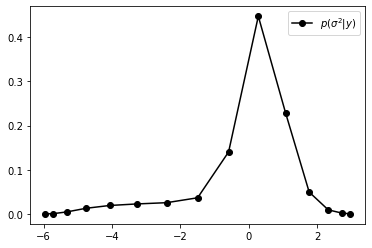

In [27]:
plt.plot(np.log10(sig2_rule.pts), post[0] * sig2_rule.wts, "ko-", label="$p(\sigma^2 | y)$")
plt.legend()
plt.show()

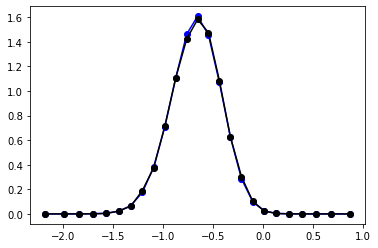

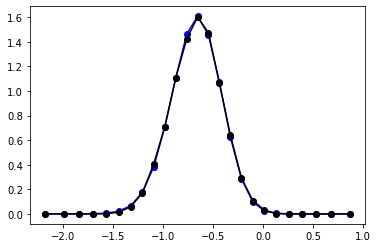

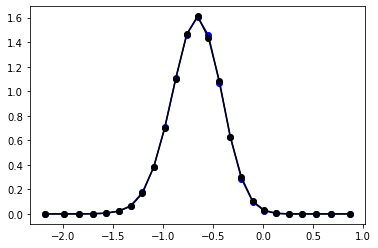

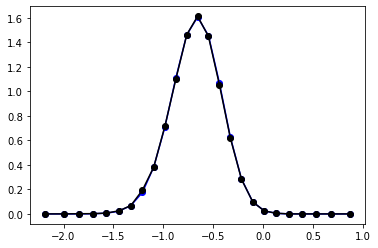

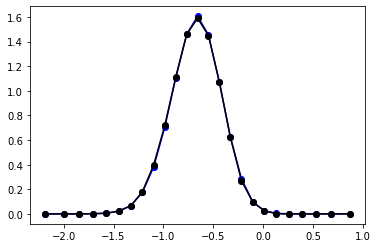

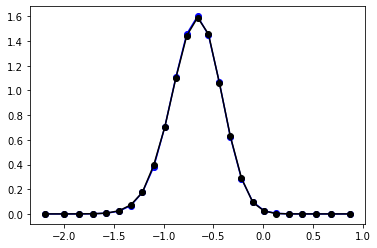

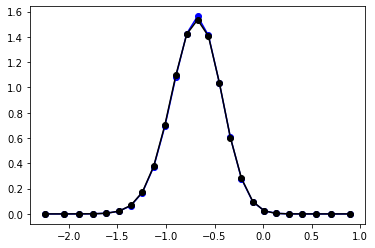

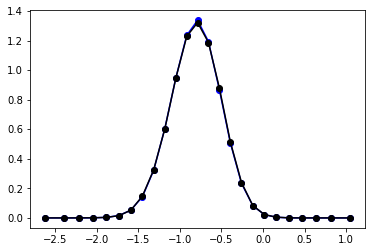

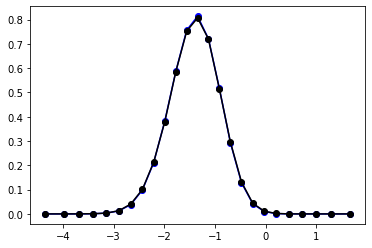

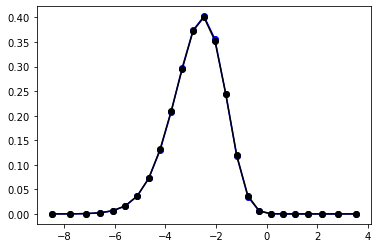

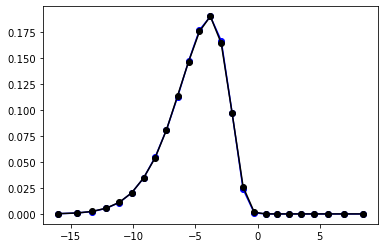

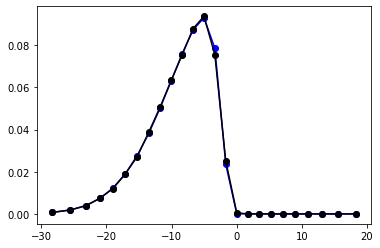

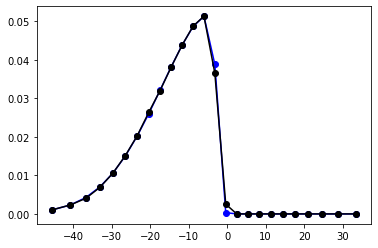

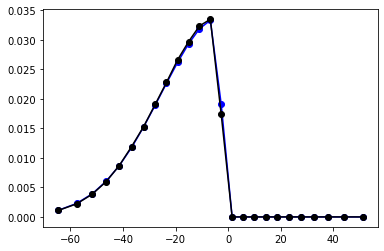

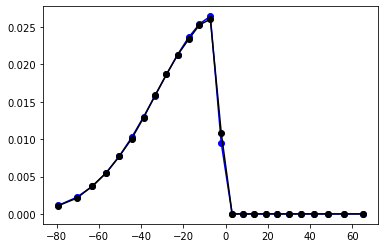

In [12]:
import matplotlib.pyplot as plt
for i in range(15):
    plt.plot(cx[:, 0, i], arm_marg[:, 0, i], 'b-o')
    plt.plot(cx[:, 0, i], mcmc_test_data[:, i, 1], 'k-o')
    plt.show()

In [17]:
divergence = inla.jensen_shannon_div(arm_marg[:, 0, :], mcmc_test_data[..., 1], wts[:, 0, :], axis=0)

DeviceArray([1.04143232e-04, 3.07438844e-04, 6.45982416e-05,
             9.89656738e-05, 7.83444433e-05, 4.13895995e-05,
             2.81239500e-05, 1.96616409e-05, 3.00670662e-05,
             2.55080402e-05, 7.19278681e-05, 1.96892343e-04,
             1.42703595e-03, 1.01020761e-04, 1.32290054e-04],            dtype=float64)